In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetB2

In [2]:
directory_root = "Dataset"
print(len(listdir(directory_root)))

24


In [3]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:

img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))


                                          image_path  \
0  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
1  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
2  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
3  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   
4  Dataset/Corn_(maize)___Cercospora_leaf_spot Gr...   

                                               label  
0  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
1  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
2  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
3  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
4  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
24592


In [5]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
24587,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,23
24588,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,23
24589,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,23
24590,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,23
24591,Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,23


In [6]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.ANTIALIAS)  
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))

C:\Users\jobin\AppData\Local\Temp\ipykernel_3456\2472196027.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, PIL.Image.ANTIALIAS)


24592


In [7]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(24592, 64, 64, 3)


In [8]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=len(listdir(directory_root)))
print(Y.shape, Y_one_hot.shape)

(24592,) (24592, 24)


In [11]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(19673, 64, 64, 3) (2459, 64, 64, 3) (2460, 64, 64, 3) (19673, 24) (2459, 24) (2460, 24)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = len(listdir(directory_root))

model = models.Sequential()
model.add(EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape, drop_connect_rate=0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                              factor=0.2,
                                              mode="min",
                                              min_lr=1e-6,
                                              patience=2,
                                              verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min",
                                         patience=3,
                                         verbose=1,
                                         restore_best_weights=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 2, 2, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                6

Training model...
Epoch 1/100



308/308 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7934
Epoch 1: val_loss improved from inf to 4.89263, saving model to efnetb3_m1_h5.h5


c:\Users\jobin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 168s 467ms/step - loss: 0.6757 - accuracy: 0.7934 - val_loss: 4.8926 - val_accuracy: 0.0659 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9231
Epoch 2: val_loss did not improve from 4.89263
308/308 [==============================] - 141s 459ms/step - loss: 0.2403 - accuracy: 0.9231 - val_loss: 11.2926 - val_accuracy: 0.0704 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9454
Epoch 3: val_loss improved from 4.89263 to 3.91803, saving model to efnetb3_m1_h5.h5
308/308 [==============================] - 141s 459ms/step - loss: 0.1634 - accuracy: 0.9454 - val_loss: 3.9180 - val_accuracy: 0.0773 - lr: 0.0010
Epoch 4/100
308/308 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9581
Epoch 4: val_loss did not improve from 3.91803
308/308 [==============================] - 140s 455ms/step - loss: 0.1346 - accuracy:

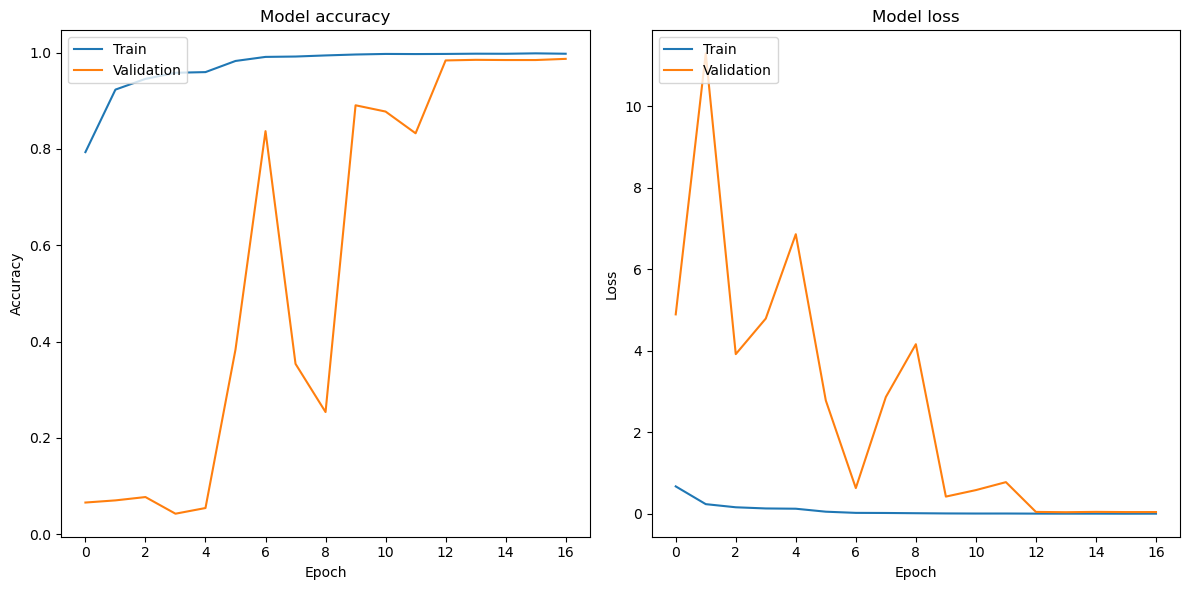

77/77 [==============================] - 5s 65ms/step - loss: 0.0371 - accuracy: 0.9878
Test Loss: 0.03712482377886772
Test Accuracy: 0.9878048896789551
77/77 [==============================] - 7s 66ms/step
Confusion Matrix:
[[154   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  5   0   0 179   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   0   0   0   0  50   1   5   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   3   0  34   0   0   0   0   0   0   0   0   

In [14]:
# Model Checkpoint
best_model_file = "efnetb3_m1_h5.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[rlronp, estop, best_model]
)

print('Training finished.')

# Visualize training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = load_model(best_model_file)

# Evaluate the best model on the test set
model.evaluate(X_test, Y_test)

# Evaluate the best model on the test set and compute accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(Y_true_labels, Y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_true_labels, Y_pred_labels))


In [15]:
import tensorflow as tf

def convert_h5_to_tflite(h5_path, tflite_path):
    # Load the model from the HDF5 file
    model = tf.keras.models.load_model(h5_path)

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model to a file
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

# Specify the paths for your HDF5 and TFLite files
h5_file_path = 'efnetb3_m1_h5.h5'
tflite_file_path = 'efnetb3_m1_tflite.tflite'

# Call the function to convert the HDF5 model to TFLite
convert_h5_to_tflite(h5_file_path, tflite_file_path)


INFO:tensorflow:Assets written to: C:\Users\jobin\AppData\Local\Temp\tmpqwj1626m\assets


INFO:tensorflow:Assets written to: C:\Users\jobin\AppData\Local\Temp\tmpqwj1626m\assets
